In [4]:
import ipywidgets as widgets
import pyhf
import json
import matplotlib.pyplot as plt
import numpy as np
from pyhf.contrib.viz import brazil
import matplotlib
pyhf.set_backend(pyhf.tensor.numpy_backend(),pyhf.optimize.minuit_optimizer())

# modify "upperlimit" def. Adding a new parameter "calctype_results"

In [5]:
"""Interval estimation"""
__all__ = ["upperlimit"]


def __dir__():
    return __all__


def _interp(x, xp, fp):
    tb, _ = get_backend()
    return tb.astensor(np.interp(x, xp.tolist(), fp.tolist()))


def upperlimit(data, model, scan, level=0.05, return_results=False, calctype_results="asymptotics"):
    
    tb, _ = get_backend()
    results = [
        hypotest(mu, data, model, test_stat="qtilde", return_expected_set=True, calctype=calctype_results)
        for mu in scan
    ]
    obs = tb.astensor([[r[0]] for r in results])
    exp = tb.astensor([[r[1][idx] for idx in range(5)] for r in results])

    result_arrary = tb.concatenate([obs, exp], axis=1).T

    # observed limit and the (0, +-1, +-2)sigma expected limits
    limits = [_interp(level, result_arrary[idx][::-1], scan[::-1]) for idx in range(6)]
    obs_limit, exp_limits = limits[0], limits[1:]

    if return_results:
        return obs_limit, exp_limits, (scan, results)
    return obs_limit, exp_limits

## model :: data = 1, bg = 0

In [6]:
model = pyhf.Model(
{
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [
            1.0
          ],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            }
          ]
        },
        {
          "name": "background",
          "data": [
            0.0
          ],
          "modifiers": [
              
          ]
        }
      ]
        
    }
  ]
}
)

In [7]:
model.config.auxdata

[]

In [8]:
observations = [1.0] + model.config.auxdata

In [200]:
model.config.poi_index

0

In [10]:
poi_values = np.linspace(0.1, 5, 50)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upperlimit(
    observations, model, poi_values, level=0.05,return_results=True,calctype_results="toybased",
)
print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

/Users/souravdey/pyhf/lib/python3.7/site-packages/pyhf/optimize/opt_minuit.py:136: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


Upper limit (obs): μ = 4.7857
Upper limit (exp): μ = 2.9333


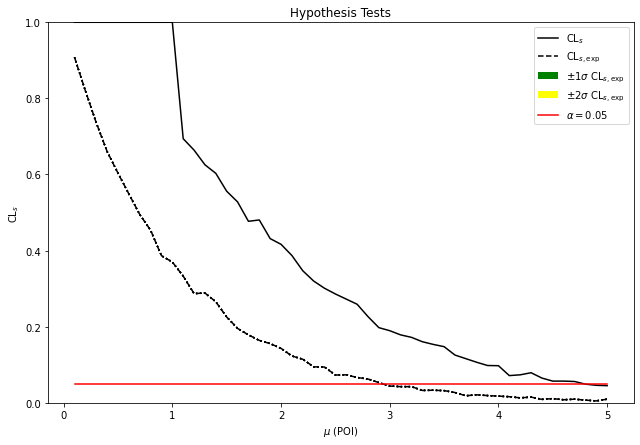

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7)
ax.set_title("Hypothesis Tests")

artists = brazil.plot_results(poi_values, results, ax=ax)

## both the bands collapse at the dotted line as there is no bg